# Peak Counts Comparisons


In [32]:
import pandas as pd
from pybedtools import BedTool as BT

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

import numpy as np
from scipy.stats import mannwhitneyu as MWU


In [1]:
def ann(x1,x2,y,text):
    '''helper function to annotate figures with text'''
    h, col = 1, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
    plt.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color=col)

## Needed data:

### 1.    Assignment of genome regions to genes 
     
We assign a BASAL region to each gene, it starts from its TSS and extends 5kb upstream and 1kb downstream,
or untill it encounters another TSS. 

For the GREAT region, we extend the BASAL region UP TO 1Mb in each way, or until a BASAL
region of another gene is encountered
 

In [4]:
greg = {}

greg['Dre'] = pd.read_csv("/home/ska/panos/d_great/zebra_GRCz10.80_GREAT_Aug.bed", sep='\t', header=None)
greg['Dre'].columns = ['chrom','start','end','geneID','score','strand']
greg['Dre']['score'] = greg['Dre']['end'] - greg['Dre']['start']

greg['Bla'] = pd.read_csv("/home/ska/panos/d_great/amphi_GREAT_Aug.bed", sep='\t', header=None)
greg['Bla'].columns = ['chrom','start','end','geneID','score','strand']
greg['Bla']['score'] = greg['Bla']['end'] - greg['Bla']['start']

greg['Ola'] = pd.read_csv("/home/ska/panos/d_great/medaka_orylat2.85_GREAT_Aug.bed", sep='\t', header=None)
greg['Ola'].columns = ['chrom','start','end','geneID','score','strand']
greg['Ola']['score'] = greg['Ola']['end'] - greg['Ola']['start']

greg['Mmu'] = pd.read_csv("/home/ska/panos/d_great/mm10_GREAT_Aug.bed", sep='\t', header=None)
greg['Mmu'].columns = ['chrom','start','end','geneID','score','strand']
greg['Mmu']['score'] = greg['Mmu']['end'] - greg['Mmu']['start']

print( [(k,len(v)) for k,v in greg.items()])

[('Mmu', 18842), ('Bla', 20569), ('Dre', 20053), ('Ola', 15978)]


In [217]:
greg['Mmu'].head()

,chrom,start,end,geneID,score,strand
0,chr1,2670503,4359310,ENSMUSG00000051951,1688807,-
1,chr1,3676503,4495409,ENSMUSG00000025900,818906,-
2,chr1,4365319,4784706,ENSMUSG00000025902,419387,-
3,chr1,4501418,4802819,ENSMUSG00000033845,301401,-
4,chr1,4790715,4852810,ENSMUSG00000025903,62095,+


### 2. ATACseq peaks

In [18]:
stages = {}
stages['Bla'] = ['8','15','36','60']
stages['Dre'] = ["dome","shield","80epi","8som","24h","48h"]
stages['Ola'] = ["dome","shield","8som","24h","48h"]
stages['Mmu'] = ['DE','ED']

In [9]:
pre_ = '/home/ska/panos/boxes/a_peaks/pools/'

peak_beds = {}

peak_beds['Dre'] = [ (BT("{}zebra_danRer10_{}_propidr.narrowPeak".format(pre_,x))
                    .sort()
                    )for x in stages['Dre']]
peak_beds['Bla'] = [(BT("{}amphi_{}_propidr.narrowPeak".format(pre_,x))
                     .sort()
                     ) for x in stages['Bla']]
peak_beds['Ola'] = [ (BT("{}medaka_{}_propidr.narrowPeak".format(pre_,x))
                    .sort()
                    )for x in stages['Ola']]
peak_beds['Mmu'] = [
    (BT("/home/ska/panos/boxes/o_mouse_early/downloads/DE_optimal_idr.narrowPeak").sort()),
    (BT("/home/ska/panos/boxes/o_mouse_early/downloads/ED_optimal_idr.narrowPeak").sort()),
]

### 3. Grouping of genes into homologous-families       

We have in our disposal a precomputed table where genes of various species
are separated into homologous families.

Each row is a family, each column a species. 
The paralogues of each species are separated with ":" so when we load this dataset
we split the strings into lists.

We also create a second dataframe "genefamsC" which has the same index and shape as the first one,
but contains the count of genes in each cell.

In [10]:
genefams = pd.read_csv("/home/ska/panos/d_gene_fams/MANU_FINAL_GENE_FAMS_WITH_DME_AND_REASONABLE_FORMAT_again.txt",
                      sep='\t')
genefams = genefams.applymap(lambda x: x.split(":") if x==x else x)

genefamsC = genefams.applymap(lambda x: len(x) if x==x else 0)

In [177]:
# Make some masks for the dataframe
mask_oto = (genefamsC['Bla']==1) & (genefamsC['Mmu']==1)  # 1-1
mask_ottw = (genefamsC['Bla']==1) & (genefamsC['Mmu']==2) # 1-2
mask_otth = (genefamsC['Bla']==1) & (genefamsC['Mmu']==3) # 1-3
mask_otfo = (genefamsC['Bla']==1) & (genefamsC['Mmu']==4) # 1-4

masks = [mask_oto, mask_ottw,mask_otth,mask_otfo]
titles = ['1-1','1-2','1-3','1-4']

# then some sets
oto_genes = genefams.loc[mask_oto,['Bla','Dre','Mmu','Ola']]
oto_genes = set([x for y in oto_genes.values.flatten() if y==y for x in y])
ottw_genes = genefams.loc[mask_ottw,['Bla','Dre','Mmu','Ola']]
ottw_genes = set([x for y in ottw_genes.values.flatten() if y==y for x in y])
otth_genes = genefams.loc[mask_otth,['Bla','Dre','Mmu','Ola']]
otth_genes = set([x for y in otth_genes.values.flatten() if y==y for x in y])
otfo_genes = genefams.loc[mask_otfo,['Bla','Dre','Mmu','Ola']]
otfo_genes = set([x for y in otfo_genes.values.flatten() if y==y for x in y])

# and use the sets to categorize the genes
def categorize(x):
    if x in oto_genes:
        return '1-1'
    elif x in ottw_genes:
        return '1-2'
    elif x in otth_genes:
        return '1-3'
    elif x in otfo_genes:
        return '1-4'
    else:
        return 'nop'

### 4.  Grouping of genes 
#### > Depending on their 'fate'    
    
This is based on the transcriptomic activity of the ohnologues in each vertebrate and is created in another analysis.

In [36]:
# this groups genes into 5 categories:
# Subfunctionalized, REdundant, SpecializedStrong,SpecializedMild, SpecializedEqual
fate_dict_zebra = dict(pd.read_csv("/home/ska/panos/d_postWGD_fates/Gene_types-Dre-v3.txt", sep='\t',header=None).set_index(0)[1])
fate_dict_mouse = dict(pd.read_csv("/home/ska/panos/d_postWGD_fates/Gene_types-Mmu-v3.txt", sep='\t',header=None).set_index(0)[1])

FATE_ORDER = ['REDUNDANT','SUBFUNCT','SPEC_EQUAL', 'SPEC_MILD','SPEC_STRONG']

#### > Depending on how many domains they lost
    
We used 9 homologous tissues for which we had RNAseq data in both species.    
We then kept genes that were active in all amphioxus experiments and their homologues in the vertebrate species. 
We finally split the vertebrate genes in categories, according to how many tissues they
had lost expression in.

In [50]:
domLost_dict_zebra = dict(pd.read_csv("/home/ska/panos/d_postWGD_fates/Spec_genes_byLost-Dre-v3.txt", sep='\t',header=None).set_index(0)[1])
domLost_dict_mouse = dict(pd.read_csv("/home/ska/panos/d_postWGD_fates/Spec_genes_byLost-Mmu-v3.txt", sep='\t',header=None).set_index(0)[1])
grouperino = {0:'0',1:'1-2',2:'1-2',3:'3-4',4:'3-4',5:'5-6',6:'5-6',7:'7-9',8:'7-9',9:'7-9'}

domLost_ORDER = ['0','1-2','3-4','5-6','7-9']

#### > House keeping vs Trans-Dev
    
Here we split genes in House-keeping, Trans-Dev and "others"

In [73]:
hkgenes = pd.read_csv("/home/ska/panos/d_gene_fams/List_of_House_keeping-Sce_1to1-noDev-clusters-v3.tab",sep='\t', header=None)
hkgenes = set(hkgenes.loc[hkgenes[1].isin(['Dre','Mmu','Bla']),2].values)
tdgenes = pd.read_csv("/home/ska/panos/d_gene_fams/List_of_transdev_TF-SF-SIGN_DEV-DIFF-clusters-v3.tab",sep='\t', header=None)
tdgenes = set(tdgenes.loc[tdgenes[1].isin(['Dre','Mmu','Bla']),2].values)

tdhk_ORDER = ['houseK','others','transD']

## Count peaks in the genomic regions of genes

Here we put our data together to end up with a count , per gene, of how many peaks
were active in its GREAT region, per stage

In [19]:
bedfields = ['chrom','start','end','name','score','strand']
big = {}

big['Dre'] = BT().from_dataframe(greg['Dre']).sort()
for bee in peak_beds['Dre']:
    big['Dre'] = big['Dre'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
# we add an extra stage of merged peaks, the peaks of all other stages merged with bedtools
mergedpeaks = BT("/home/ska/panos/boxes/a_peaks/final_peaks/zebra_danRer10_merged.bed").sort()
big['Dre'] = (big['Dre']
              .intersect(b = mergedpeaks, c=True, sorted=True, nonamecheck=True) 
              .to_dataframe(names=range(13)))
big['Dre'].columns = bedfields + stages['Dre'] + ['merged']

# the other species:
big['Bla'] = BT().from_dataframe(greg['Bla']).sort()
for bee in peak_beds['Bla']:
    big['Bla'] = big['Bla'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Bla'] = big['Bla'].to_dataframe()
big['Bla'].columns = bedfields + stages['Bla']

big['Ola'] = BT().from_dataframe(greg['Ola']).sort()
for bee in peak_beds['Ola']:
    big['Ola'] = big['Ola'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Ola'] = big['Ola'].to_dataframe()
big['Ola'].columns = bedfields + stages['Ola']

big['Mmu'] = BT().from_dataframe(greg['Mmu']).sort()
for bee in peak_beds['Mmu']:
    big['Mmu'] = big['Mmu'].intersect(b = bee, c=True, sorted=True, nonamecheck=True)
big['Mmu'] = big['Mmu'].to_dataframe()
big['Mmu'].columns = bedfields + stages['Mmu']

In [21]:
big['Dre'].head()

,chrom,start,end,name,score,strand,dome,shield,80epi,8som,24h,48h,merged
0,MT,0,4804,ENSDARG00000063895,4804,+,0,0,0,0,0,0,0
1,MT,3805,5994,ENSDARG00000063899,2189,+,0,0,0,0,0,0,0
2,MT,4995,7426,ENSDARG00000063905,2431,+,0,0,0,0,0,0,0
3,MT,6427,8893,ENSDARG00000063908,2466,+,0,0,0,0,0,0,0
4,MT,8132,9051,ENSDARG00000063910,919,+,0,0,0,0,0,0,0


In [218]:
# set the gene ID as index in all dataframes of 'big'
big_ind = {}
for k,v in big.items():
    big_ind[k] = v.set_index('name')
    big_ind[k].columns = [str(x) for x in big_ind[k].columns]

## Final manipulations and plots

### By fate

#### Zebrafish

In [26]:
# GEt a working copy of the peak count dataframe:
dd = big_ind['Dre'].copy()
# map the fate category
dd['genecat'] = dd.index.to_series().map(fate_dict_zebra)
dd = dd[~dd.genecat.isnull()]
dd.head()

,chrom,start,end,score,strand,dome,shield,80epi,8som,24h,48h,merged,genecat
name,,,,,,,,,,,,,
ENSDARG00000096578,chr1,157565,166311,8746,+,2,4,2,2,2,2,2,REDUNDANT
ENSDARG00000100181,chr1,158798,195876,37078,+,6,5,8,3,4,7,9,SPEC_MILD
ENSDARG00000041592,chr1,219453,244893,25440,-,4,5,8,6,9,8,9,SPEC_MILD
ENSDARG00000104279,chr1,624409,673560,49151,-,10,13,13,18,15,19,20,SPEC_EQUAL
ENSDARG00000001870,chr1,1484800,1559342,74542,+,7,6,7,13,11,15,17,SPEC_MILD


In [38]:
# Get our data in tidy format:
toplot = pd.melt(dd[['merged','genecat']], id_vars=['genecat'])
toplot.head()

,genecat,variable,value
0,REDUNDANT,merged,2
1,SPEC_MILD,merged,9
2,SPEC_MILD,merged,9
3,SPEC_EQUAL,merged,20
4,SPEC_MILD,merged,17


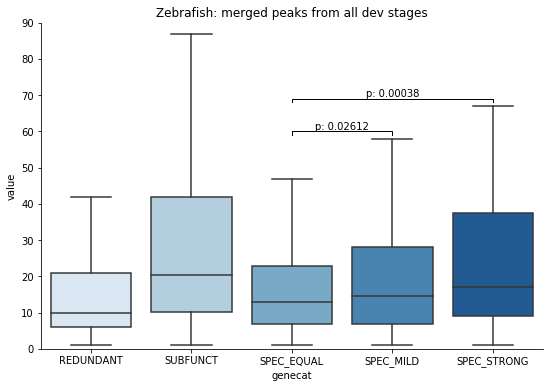

In [40]:
# Plot:
plt.figure(figsize=(9,6))

sns.boxplot(data = toplot, 
            x = 'genecat',  
            y='value',
            fliersize=0, 
            palette='Blues',
            order = FATE_ORDER)
plt.ylim((0,90))


# We want to annotate the plot with a Mann-Whitney test pval:
# First we need the values from each box:
EL = [ toplot.loc[toplot.genecat==i,'value'].values for i in FATE_ORDER]

# Then we compute the edge of the boxplot
# https://stackoverflow.com/questions/36423362/about-boxplot-whiskers-calculation-with-numpy-or-matplotlib
HIP = []
for vals in EL:
    Q1, median, Q3 = np.percentile(vals, [25, 50, 75])
    hival = np.compress(vals <= Q3 + 1.5 * (Q3 - Q1), vals).max() +1
    HIP.append(hival)
    
# We have the height where we want to annotate (in HIP)
# we now get the pvalue:
pv = MWU(EL[2], EL[3], alternative='less')[1]
# and use our helper function to annotate the graph:
ann(2,3,HIP[3],"p: {0:.5f}".format(pv))

pv = MWU(EL[2], EL[4], alternative='less')[1]
ann(2,4,HIP[4],"p: {0:.5f}".format(pv))

sns.despine()
plt.title('Zebrafish: merged peaks from all dev stages')

#### Mouse

In [57]:
dd = big_ind['Mmu'].copy()
dd['genecat'] = dd.index.to_series().map(fate_dict_mouse)
dd = dd[~dd.genecat.isnull()]
dd.head(2)

,chrom,start,end,score,strand,DE,ED,genecat
name,,,,,,,,
ENSMUSG00000025903,chr1,4790715,4852810,62095,+,3,5,SPEC_MILD
ENSMUSG00000033813,chr1,4808828,5018535,209707,+,21,20,SUBFUNCT


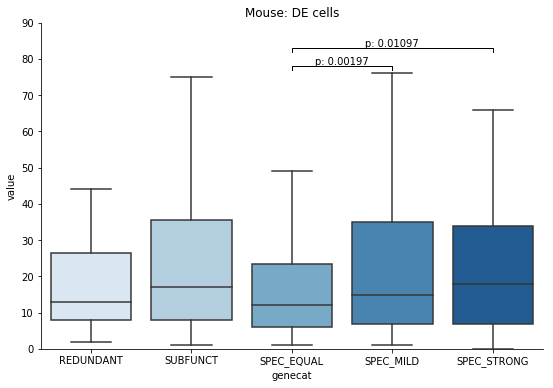

In [62]:
toplot = pd.melt(dd[['DE','genecat']], id_vars=['genecat'])

plt.figure(figsize=(9,6))
sns.boxplot(data = toplot, x = 'genecat',  y='value',
           fliersize=0, palette='Blues',
           order = FATE_ORDER)
plt.ylim((0,90))
EL = [ toplot.loc[toplot.genecat==i,'value'].values for i in FATE_ORDER]
HIP = []
for buz in EL:
    Q1, median, Q3 = np.percentile(buz, [25, 50, 75])
    hival = np.compress(buz <= Q3 + 1.5 * (Q3 - Q1), buz).max() +1
    HIP.append(hival)   
pv = MWU(EL[2], EL[3], alternative='less')[1]
ann(2,3,HIP[3],"p: {0:.5f}".format(pv))
pv = MWU(EL[2], EL[4], alternative='less')[1]
ann(2,4,HIP[3]+5,"p: {0:.5f}".format(pv))
sns.despine()
plt.title('Mouse: DE cells')

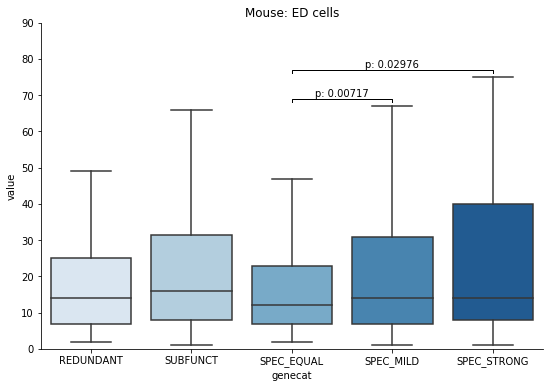

In [63]:
toplot = pd.melt(dd[['ED','genecat']], id_vars=['genecat'])
plt.figure(figsize=(9,6))
sns.boxplot(data = toplot, x = 'genecat',  y='value',
           fliersize=0, palette='Blues',
           order = FATE_ORDER)
plt.ylim((0,90))
EL = [ toplot.loc[toplot.genecat==i,'value'].values for i in FATE_ORDER]
HIP = []
for buz in EL:
    Q1, median, Q3 = np.percentile(buz, [25, 50, 75])
    hival = np.compress(buz <= Q3 + 1.5 * (Q3 - Q1), buz).max() +1
    HIP.append(hival)   
pv = MWU(EL[2], EL[3], alternative='less')[1]
ann(2,3,HIP[3],"p: {0:.5f}".format(pv))
pv = MWU(EL[2], EL[4], alternative='less')[1]
ann(2,4,HIP[4],"p: {0:.5f}".format(pv))
sns.despine()
plt.title('Mouse: ED cells')

### Genes groupped by domains lost

#### Zebrafish

In [64]:
# GEt a working copy of the peak count dataframe:
dd = big_ind['Dre'].copy()
# map the fate category
dd['genecat'] = dd.index.to_series().map(domLost_dict_zebra)
dd = dd[~dd.genecat.isnull()]
dd['genecat'] = dd['genecat'].map(grouperino)
dd.head()

,chrom,start,end,score,strand,dome,shield,80epi,8som,24h,48h,merged,genecat
name,,,,,,,,,,,,,
ENSDARG00000100181,chr1,158798,195876,37078,+,6,5,8,3,4,7,9,1-2
ENSDARG00000041592,chr1,219453,244893,25440,-,4,5,8,6,9,8,9,1-2
ENSDARG00000104279,chr1,624409,673560,49151,-,10,13,13,18,15,19,20,0
ENSDARG00000001870,chr1,1484800,1559342,74542,+,7,6,7,13,11,15,17,5-6
ENSDARG00000002791,chr1,1542986,1763169,220183,+,17,16,17,20,18,19,30,0


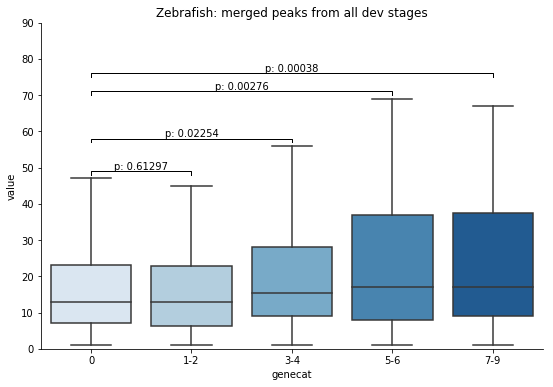

In [65]:
toplot = pd.melt(dd[['merged','genecat']], id_vars=['genecat'])

plt.figure(figsize=(9,6))
sns.boxplot(data = toplot, x = 'genecat',  y='value',
           fliersize=0, palette='Blues',
           order = domLost_ORDER)
plt.ylim((0,90))
EL = [ toplot.loc[toplot.genecat==i,'value'].values for i in domLost_ORDER]
HIP = []
for buz in EL:
    Q1, median, Q3 = np.percentile(buz, [25, 50, 75])
    hival = np.compress(buz <= Q3 + 1.5 * (Q3 - Q1), buz).max() +1
    HIP.append(hival)  
pv = MWU(EL[0], EL[1], alternative='less')[1]
ann(0,1,HIP[0],"p: {0:.5f}".format(pv))
pv = MWU(EL[0], EL[2], alternative='less')[1]
ann(0,2,HIP[2],"p: {0:.5f}".format(pv))
pv = MWU(EL[0], EL[3], alternative='less')[1]
ann(0,3,HIP[3],"p: {0:.5f}".format(pv))
pv = MWU(EL[0], EL[4], alternative='less')[1]
ann(0,4,HIP[3]+5,"p: {0:.5f}".format(pv))
sns.despine()
plt.title('Zebrafish: merged peaks from all dev stages')

#### Mouse

In [220]:
dd = big_ind['Mmu'].copy()
dd['genecat'] = dd.index.to_series().map(domLost_dict_mouse)
dd['genecat'] = dd['genecat'].map(grouperino)
dd = dd[~dd.genecat.isnull()]
dd.head(2)

,chrom,start,end,score,strand,DE,ED,genecat
name,,,,,,,,
ENSMUSG00000025903,chr1,4790715,4852810,62095,+,3,5,1-2
ENSMUSG00000025933,chr1,21084234,21235585,151351,+,23,17,7-9


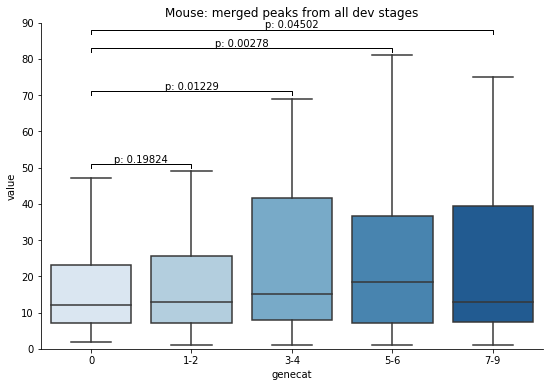

In [221]:
toplot = pd.melt(dd[['ED','genecat']], id_vars=['genecat'])

plt.figure(figsize=(9,6))
sns.boxplot(data = toplot, x = 'genecat',  y='value',
           fliersize=0, palette='Blues',
           order = domLost_ORDER)

plt.ylim((0,90))
EL = [ toplot.loc[toplot.genecat==i,'value'].values for i in domLost_ORDER]
HIP = []
for buz in EL:
    Q1, median, Q3 = np.percentile(buz, [25, 50, 75])
    hival = np.compress(buz <= Q3 + 1.5 * (Q3 - Q1), buz).max() +1
    HIP.append(hival)   
pv = MWU(EL[0], EL[1], alternative='less')[1]
ann(0,1,HIP[1],"p: {0:.5f}".format(pv))
pv = MWU(EL[0], EL[2], alternative='less')[1]
ann(0,2,HIP[2],"p: {0:.5f}".format(pv))
pv = MWU(EL[0], EL[3], alternative='less')[1]
ann(0,3,HIP[3],"p: {0:.5f}".format(pv))
pv = MWU(EL[0], EL[4], alternative='less')[1]
ann(0,4,HIP[3]+5,"p: {0:.5f}".format(pv))
sns.despine()
plt.title('Mouse: merged peaks from all dev stages')

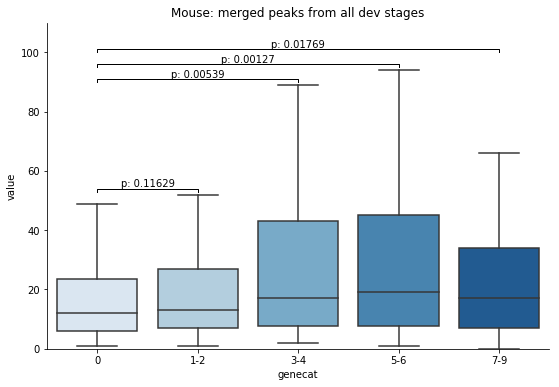

In [225]:
ddtp = pd.melt(dd[['DE','genecat']], id_vars=['genecat'])
plt.figure(figsize=(9,6))
sns.boxplot(data = ddtp, x = 'genecat',  y='value',
           fliersize=0, palette='Blues',
           order = domLost_ORDER)
plt.ylim((0,110))
EL = [ ddtp.loc[ddtp.genecat==i,'value'].values for i in domLost_ORDER]
HIP = []
for category in domLost_ORDER:
    buz = ddtp.loc[ddtp.genecat==category,'value'].values
    Q1, median, Q3 = np.percentile(buz, [25, 50, 75])
    hival = np.compress(buz <= Q3 + 1.5 * (Q3 - Q1), buz).max() +1
    HIP.append(hival)

pv = MWU(EL[0], EL[1], alternative='less')[1]
ann(0,1,HIP[1],"p: {0:.5f}".format(pv))
pv = MWU(EL[0], EL[2], alternative='less')[1]
ann(0,2,HIP[2],"p: {0:.5f}".format(pv))
pv = MWU(EL[0], EL[3], alternative='less')[1]
ann(0,3,HIP[3],"p: {0:.5f}".format(pv))
pv = MWU(EL[0], EL[4], alternative='less')[1]
ann(0,4,HIP[3]+5,"p: {0:.5f}".format(pv))

sns.despine()
plt.title('Mouse: merged peaks from all dev stages')

## Trans-dev VS House-keeping genes

In [70]:
def categ(x):
    if x in hkgenes:
        return "houseK"
    elif x in tdgenes:
        return "transD"
    else:
        return "others"

### Zebrafish

In [72]:
# GEt a working copy of the peak count dataframe:
dd = big_ind['Dre'].copy()
# map the fate category
dd['genecat'] = dd.index.to_series().map(categ)
dd = dd[~dd.genecat.isnull()]
dd.head()

,chrom,start,end,score,strand,dome,shield,80epi,8som,24h,48h,merged,genecat
name,,,,,,,,,,,,,
ENSDARG00000063895,MT,0,4804,4804,+,0,0,0,0,0,0,0,others
ENSDARG00000063899,MT,3805,5994,2189,+,0,0,0,0,0,0,0,others
ENSDARG00000063905,MT,4995,7426,2431,+,0,0,0,0,0,0,0,others
ENSDARG00000063908,MT,6427,8893,2466,+,0,0,0,0,0,0,0,others
ENSDARG00000063910,MT,8132,9051,919,+,0,0,0,0,0,0,0,others


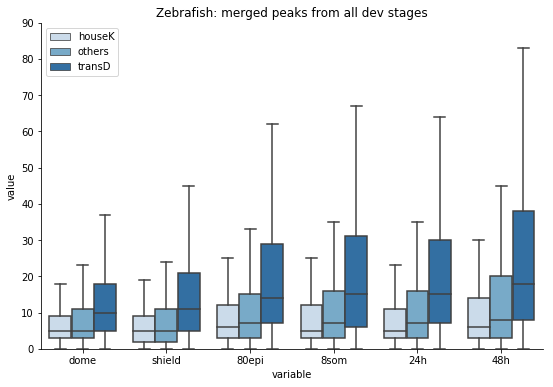

In [74]:
toplot = pd.melt(dd[stages['Dre'] +['genecat']], id_vars=['genecat'])

plt.figure(figsize=(9,6))

sns.boxplot(data = toplot, 
            hue = 'genecat',
            x='variable',  
            y='value',
            fliersize=0, 
            palette='Blues',
            hue_order = tdhk_ORDER)

plt.ylim((0,90))

sns.despine()
plt.title('Zebrafish: merged peaks from all dev stages')
plt.legend(loc='upper left')

### Mouse

In [75]:
# GEt a working copy of the peak count dataframe:
dd = big_ind['Mmu'].copy()
# map the fate category
dd['genecat'] = dd.index.to_series().map(categ)
dd = dd[~dd.genecat.isnull()]
dd.head()

,chrom,start,end,score,strand,DE,ED,genecat
name,,,,,,,,
ENSMUSG00000051951,chr1,2670503,4359310,1688807,-,98,96,others
ENSMUSG00000025900,chr1,3676503,4495409,818906,-,63,66,others
ENSMUSG00000025902,chr1,4365319,4784706,419387,-,63,61,transD
ENSMUSG00000033845,chr1,4501418,4802819,301401,-,43,42,houseK
ENSMUSG00000025903,chr1,4790715,4852810,62095,+,3,5,others


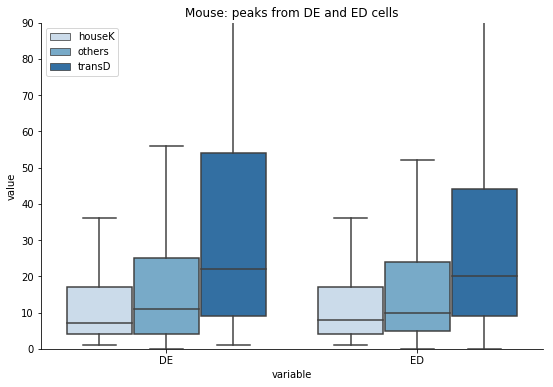

In [76]:
ddtp = pd.melt(dd[['DE','ED','genecat']], id_vars=['genecat'])


plt.figure(figsize=(9,6))

sns.boxplot(data = ddtp, hue = 'genecat',x='variable',  y='value',
           fliersize=0, palette='Blues',
           hue_order = tdhk_ORDER)

plt.ylim((0,90))


sns.despine()
plt.title('Mouse: peaks from DE and ED cells')
plt.legend(loc='upper left')

## Genes groupped by orthology

In [83]:
# apply the categorization,
# Filter non interesting genes
dd_dre = big_ind['Dre'].copy()
dd_dre['category'] = dd_dre.index.to_series().map(categorize)
dd_dre = dd_dre[dd_dre.category != 'nop']
dd_dre = dd_dre[['8som','category']]
dd_dre.columns = ['Dre_8som','category']

dd_ola = big_ind['Ola'].copy()
dd_ola['category'] = dd_ola.index.to_series().map(categorize)
dd_ola = dd_ola[dd_ola.category != 'nop']
dd_ola = dd_ola[['8som','category']]
dd_ola.columns = ['Ola_8som','category']

dd_bla = big_ind['Bla'].copy()
dd_bla['category'] = dd_bla.index.to_series().map(categorize)
dd_bla = dd_bla[dd_bla.category != 'nop']
dd_bla = dd_bla[['15','category']]
dd_bla.columns = ['Bla_15hpf','category']

# then melt the DFs from each species and concatenate those
TP = pd.concat([pd.melt(dd_dre, id_vars='category'),
            pd.melt(dd_bla, id_vars='category'),
            pd.melt(dd_ola, id_vars='category')])
TP.head(2)

,category,variable,value
0,1-1,Dre_8som,1
1,1-1,Dre_8som,1


### Zebrafish

(0, 55)

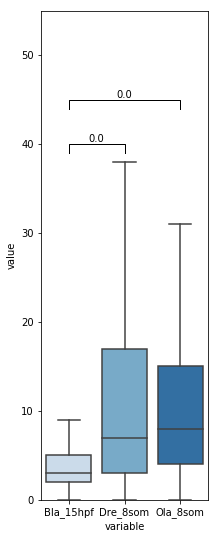

In [112]:
ORDER = ['Bla_15hpf','Dre_8som','Ola_8som']
plt.figure(figsize=(3,9))

sns.boxplot(data = TP, 
            
            x='variable',
            y='value',
           fliersize=0, palette='Blues',
            order = ORDER
           )

data = {}
HIP = {}

for ggn,gg in TP.groupby('variable'):
        buz = gg.value.values
        data[ggn] = buz
        Q1, median, Q3 = np.percentile(buz, [25, 50, 75])
        hival = np.compress(buz <= Q3 + 1.5 * (Q3 - Q1), buz).max() +1
        HIP[ggn] = hival
        
pv = MWU( data['Dre_8som'], data['Bla_15hpf'], alternative='greater')[1]
y = HIP['Dre_8som']
ann(0,1, y, "{}".format(pv))

pv = MWU( data['Ola_8som'], data['Bla_15hpf'], alternative='greater')[1]

ann(0,2, y+5, "{}".format(pv))    

plt.ylim((0,55))

(0, 55)

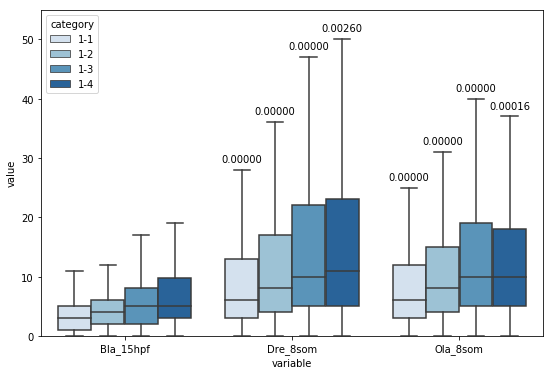

In [84]:
ORDER = ['Bla_15hpf','Dre_8som','Ola_8som']
plt.figure(figsize=(9,6))

sns.boxplot(data = TP, 
            hue = 'category',
            x='variable',
            y='value',
           fliersize=0, palette='Blues',
            order = ORDER
           )

data = {}
HIP = {}
for gn,g in TP.groupby('category'):
    data[gn] = {}
    HIP[gn] = {}
    for ggn,gg in g.groupby('variable'):
        buz = gg.value.values
        data[gn][ggn] = buz
        Q1, median, Q3 = np.percentile(buz, [25, 50, 75])
        hival = np.compress(buz <= Q3 + 1.5 * (Q3 - Q1), buz).max() +1
        HIP[gn][ggn] = hival
        
        
plt.text(0.7,
         HIP['1-1']['Dre_8som'] , 
         "{0:.5f}".format( MWU( data['1-1']['Bla_15hpf'], data['1-1']['Dre_8som'], alternative='less')[1]),
         ha='center', va='bottom', color='black')
plt.text(0.9,
         HIP['1-2']['Dre_8som'] , 
         "{0:.5f}".format( MWU( data['1-2']['Bla_15hpf'], data['1-1']['Dre_8som'], alternative='less')[1]),
         ha='center', va='bottom', color='black')
plt.text(1.1,
         HIP['1-3']['Dre_8som'] , 
         "{0:.5f}".format( MWU( data['1-3']['Bla_15hpf'], data['1-1']['Dre_8som'], alternative='less')[1]),
         ha='center', va='bottom', color='black')
plt.text(1.3,
         HIP['1-4']['Dre_8som'] , 
         "{0:.5f}".format( MWU( data['1-4']['Bla_15hpf'], data['1-1']['Dre_8som'], alternative='less')[1]),
         ha='center', va='bottom', color='black')

plt.text(1.7,
         HIP['1-1']['Ola_8som'] , 
         "{0:.5f}".format( MWU( data['1-1']['Bla_15hpf'], data['1-1']['Ola_8som'], alternative='less')[1]),
         ha='center', va='bottom', color='black')
plt.text(1.9,
         HIP['1-2']['Ola_8som'] , 
         "{0:.5f}".format( MWU( data['1-2']['Bla_15hpf'], data['1-1']['Ola_8som'], alternative='less')[1]),
         ha='center', va='bottom', color='black')
plt.text(2.1,
         HIP['1-3']['Ola_8som'] , 
         "{0:.5f}".format( MWU( data['1-3']['Bla_15hpf'], data['1-1']['Ola_8som'], alternative='less')[1]),
         ha='center', va='bottom', color='black')
plt.text(2.3,
         HIP['1-4']['Ola_8som'] , 
         "{0:.5f}".format( MWU( data['1-4']['Bla_15hpf'], data['1-1']['Ola_8som'], alternative='less')[1]),
         ha='center', va='bottom', color='black')

plt.ylim((0,55))

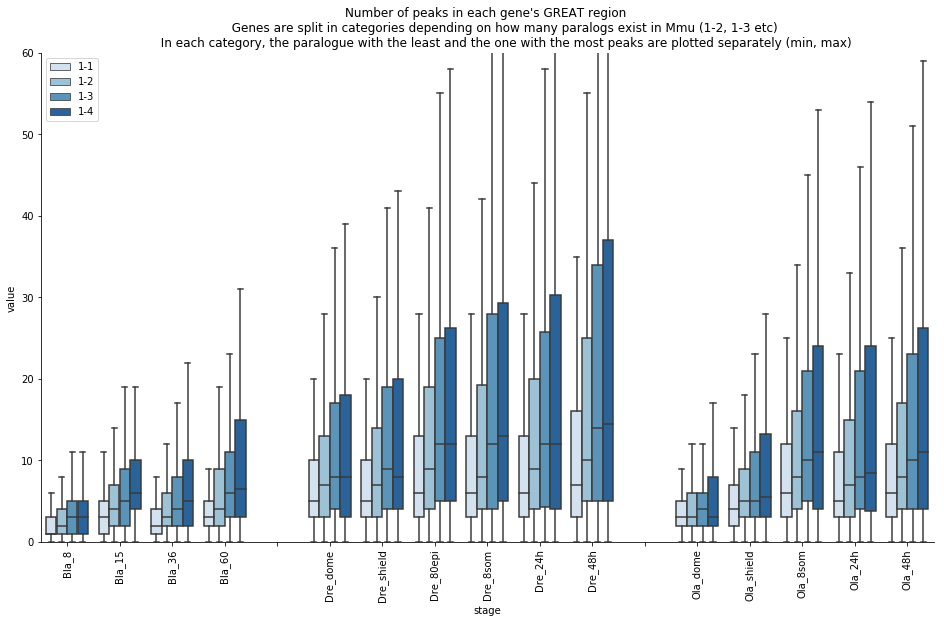

In [226]:
o = ['Bla_8','Bla_15','Bla_36','Bla_60',' ',
    'Dre_dome','Dre_shield','Dre_80epi','Dre_8som','Dre_24h','Dre_48h',' ',
    'Ola_dome','Ola_shield','Ola_8som','Ola_24h','Ola_48h']


toplot = bigmelt3.copy()
toplot['hew'] = toplot.title  + toplot.variable

plt.figure(figsize=(16,9))

g = sns.boxplot(
            
            x="stage",
            y="value",
            hue="title",
            fliersize=0,
            order=o,
            palette = 'Blues',
#             order=['Bla_15','Dre_8som','Ola_8som'],
            data=toplot
            )
plt.legend(loc='upper left')
sns.despine()

plt.title("Number of peaks in each gene's GREAT region \n\
          Genes are split in categories depending on how many paralogs exist in Mmu (1-2, 1-3 etc) \n\
          In each category, the paralogue with the least and the one with the most peaks are plotted separately (min, max)")

plt.ylim((0,60))

_ = g.set_xticklabels(g.xaxis.get_majorticklabels(), rotation=90)

##  Splitting min and max ohnologues

In [178]:
lot = {}
lot['Dre'] = []
lot['Bla'] = []
lot['Ola'] = []


for mask,title in zip(masks, titles):
    for i,row in genefams.loc[mask,['Bla','Dre','Ola']].iterrows():
        for spec in ['Bla','Dre','Ola']:
            try:
                lgl = row[spec]
                if lgl == lgl:
                    slaice = big_ind[spec].loc[lgl, stages[spec]]
                    slaice = pd.concat([slaice.min(),slaice.max()], axis=1)
                    slaice.columns = ['min','max']
                    slaice['stage'] = spec + "_" + slaice.index.values
                    slaice = pd.melt(slaice, id_vars=['stage'])
                    slaice['title'] = title
                    
                    lot[spec].append( slaice )
            except:
                pass
lot['Dre'] = pd.concat(lot['Dre'])
lot['Bla'] = pd.concat(lot['Bla'])
lot['Ola'] = pd.concat(lot['Ola'])


bigmelt3 = pd.concat([lot['Dre']
                     , lot['Bla']
                     , lot['Ola']])

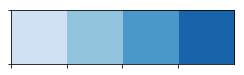

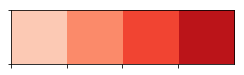

In [179]:
# a hand-made palette
bcp = sns.color_palette('Blues',4)
sns.palplot(bcp)
rcp = sns.color_palette('Reds',4)
sns.palplot(rcp)
mycp = {
#  '1-1max':(0.8141176470588235, 0.883921568627451, 0.9498039215686275),
    '1-1max':(0.9027451 ,  0.83764706,  0.82901961),
    '1-1min':(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),
    '1-2max':(0.5796078431372549, 0.7701960784313725, 0.8737254901960784),
    '1-2min':(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),
    '1-3max':(0.2909803921568628, 0.5945098039215686, 0.7890196078431373),
    '1-3min':(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),
    '1-4max':(0.09019607843137256, 0.39294117647058824, 0.6705882352941177),
    '1-4min':(0.7364705882352941, 0.08, 0.10117647058823528),
    '_':(0,0,0)}

In [180]:
oMF2 = ['Bla_15','Dre_8som','Ola_8som']
foo = bigmelt3[bigmelt3.stage.isin(oMF2)].copy()
foo['nf'] = foo.title + foo.variable

foo['norm'] = 0

(0, 60)

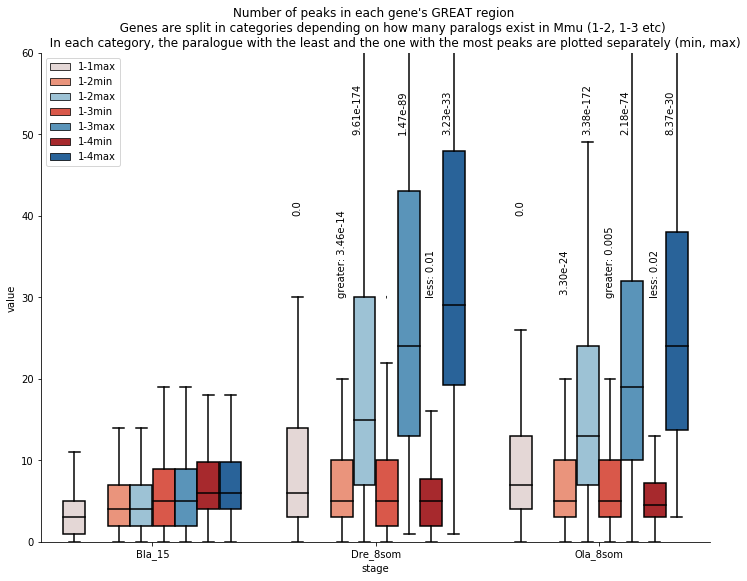

In [211]:
toplot = foo.copy()
toplot['hew'] = toplot.title  + toplot.variable

plt.figure(figsize=(12,9))

g = sns.boxplot(
            
            x="stage",
            y="value",
            hue="hew",
            fliersize=0,
            hue_order=['1-1max','_','1-2min','1-2max','1-3min','1-3max','1-4min','1-4max'],
            palette = mycp,
            order=['Bla_15','Dre_8som','Ola_8som'],
            data=toplot
            )
plt.legend(loc='upper left')
sns.despine()


# It has gotten a bit too hairy to dynamically annotate at this point
# so we'll do a bit of manual work
# The pvalues are calculated in the following cell
plt.text( 0.65 , 40, "0.0", ha='center', va='bottom',  rotation=90)
plt.text( 0.85 , 30, "greater: 3.46e-14", ha='center', va='bottom',  rotation=90)
plt.text( 0.92 , 50, "9.61e-174", ha='center', va='bottom',  rotation=90)
plt.text( 1.05 , 30, "-", ha='center', va='bottom',  rotation=90)
plt.text( 1.12 , 50, "1.47e-89", ha='center', va='bottom',  rotation=90)
plt.text( 1.25 , 30, "less: 0.01", ha='center', va='bottom',  rotation=90)
plt.text( 1.32 , 50, "3.23e-33", ha='center', va='bottom',  rotation=90)
plt.text( 1.65 , 40, "0.0", ha='center', va='bottom',  rotation=90)
plt.text( 1.85 , 30, " 3.30e-24", ha='center', va='bottom',  rotation=90)
plt.text( 1.95 , 50, "3.38e-172", ha='center', va='bottom',  rotation=90)
plt.text( 2.05 , 30, "greater: 0.005", ha='center', va='bottom',  rotation=90)
plt.text( 2.12 , 50, "2.18e-74", ha='center', va='bottom',  rotation=90)
plt.text( 2.25 , 30, "less: 0.02", ha='center', va='bottom',  rotation=90)
plt.text( 2.32 , 50, "8.37e-30", ha='center', va='bottom',  rotation=90)


plt.title("Number of peaks in each gene's GREAT region \n\
          Genes are split in categories depending on how many paralogs exist in Mmu (1-2, 1-3 etc) \n\
          In each category, the paralogue with the least and the one with the most peaks are plotted separately (min, max)")

plt.ylim((0,60))

In [212]:
sel = lambda enef,variable: toplot.loc[(toplot.hew==enef) & (toplot.stage==variable), 'value'].values
for enef in ['1-1max','1-2min','1-3min','1-4min','1-2max','1-3max','1-4max']:
    if enef.endswith("min"):
        print('Dre',enef,'less', MWU(sel(enef,'Dre_8som'),sel(enef,'Bla_15'), alternative='less')[1])
        print('Ola',enef,'less', MWU(sel(enef,'Ola_8som'),sel(enef,'Bla_15'), alternative='less')[1])
        print('Dre',enef,'more', MWU(sel(enef,'Dre_8som'),sel(enef,'Bla_15'), alternative='greater')[1])
        print('Ola',enef,'more', MWU(sel(enef,'Ola_8som'),sel(enef,'Bla_15'), alternative='greater')[1])
    else:
        print('Dre',enef,'more', MWU(sel(enef,'Dre_8som'),sel(enef,'Bla_15'), alternative='greater')[1])
        print('Ola',enef,'more', MWU(sel(enef,'Ola_8som'),sel(enef,'Bla_15'), alternative='greater')[1])

('Dre', '1-1max', 'more', 0.0)
('Ola', '1-1max', 'more', 0.0)
('Dre', '1-2min', 'less', 0.99999999999996547)
('Ola', '1-2min', 'less', 1.0)
('Dre', '1-2min', 'more', 3.459507310252893e-14)
('Ola', '1-2min', 'more', 3.3047851343871662e-24)
('Dre', '1-3min', 'less', 0.66659114337340575)
('Ola', '1-3min', 'less', 0.99464562024448655)
('Dre', '1-3min', 'more', 0.33350122204750859)
('Ola', '1-3min', 'more', 0.0053583481767077784)
('Dre', '1-4min', 'less', 0.015763434616092996)
('Ola', '1-4min', 'less', 0.028104217143940482)
('Dre', '1-4min', 'more', 0.98429894545485386)
('Ola', '1-4min', 'more', 0.97199877782001332)
('Dre', '1-2max', 'more', 9.6127869431728075e-174)
('Ola', '1-2max', 'more', 3.3811788730221686e-172)
('Dre', '1-3max', 'more', 1.4682607834187557e-89)
('Ola', '1-3max', 'more', 2.1794964873640723e-74)
('Dre', '1-4max', 'more', 3.2280779910634794e-33)
('Ola', '1-4max', 'more', 8.3695742514410374e-30)


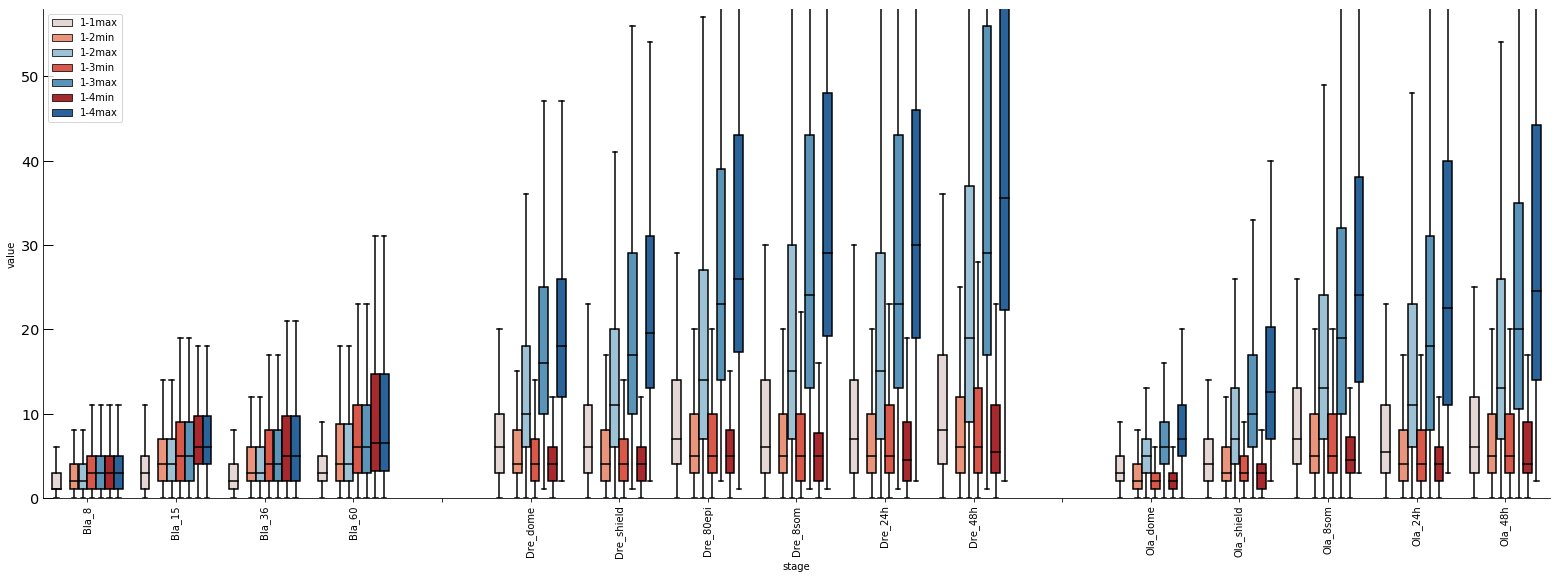

In [216]:
o = ['Bla_8','Bla_15','Bla_36','Bla_60',' ',
    'Dre_dome','Dre_shield','Dre_80epi','Dre_8som','Dre_24h','Dre_48h',' ',
    'Ola_dome','Ola_shield','Ola_8som','Ola_24h','Ola_48h']

foo = bigmelt3[bigmelt3.stage.isin(o)].copy()
foo['nf'] = foo.title + foo.variable
foo['norm'] = 0
fig, ax = plt.subplots(figsize=(27,9))


g = sns.boxplot(
            
            x="stage",
            y="value",
            hue="nf",
            fliersize=0,
            hue_order=['1-1max','_','1-2min','1-2max','1-3min','1-3max','1-4min','1-4max'],
            palette = mycp,
            order=o,
#             palette='Blues',
            
            data=foo,
            ax=ax
            )
plt.legend(loc='upper left')
sns.despine()


# plt.title("Number of peaks in each gene's GREAT region \n\
#           Genes are split in categories depending on how many paralogs exist in Mmu (1-2, 1-3 etc) \n\
#           In each category, the paralogue with the least and the one with the most peaks are plotted separately (min, max)")

ax.set_ylim((0,58))



ax.tick_params(direction ='in', axis='y',
               length=10, width=1, colors='black',labelsize='x-large')
_ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)

sns.despine()